# PPO实现CarPole-v1（离散动作空间）

## 1. 定义算法

### 1.1 定义模型

定义PPO的两个主要的网络：PPO_Actor和PPO_Critic

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class ActorSoftmax(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        probs = F.softmax(x,dim=1)
        return probs

class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super().__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        value = self.fc3(x)
        return value

### 1.2 定义经验回放

In [12]:
import random
from collections import deque
class ReplayBufferQue:
    '''DQN的经验回放池，每次采样batch_size个样本'''
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity # 经验回放池的容量
        self.buffer = deque(maxlen=self.capacity) # 生成队列，先进先出
    
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions) # 添加一个transition
    
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    
    def clear(self):
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)

# PPO的策略梯度算法，因此不需要采样batch_size个样本，直接采样所有样本
class PGReplay(ReplayBufferQue): 
    '''PG的经验回放池，每次采样所有样本，因此只需要继承ReplayBufferQue，重写sample方法即可
    '''
    def __init__(self):
        self.buffer = deque()
    
    def sample(self):
        ''' sample all the transitions
        '''
        batch = list(self.buffer)
        return zip(*batch)

### 1.3 定义智能体

In [13]:
import torch
from torch.distributions import Categorical

class Agent:
    def __init__(self,cfg) -> None:
        
        # 定义折扣因子γ
        self.gamma = cfg.gamma

        # 定义设备
        self.device = torch.device(cfg.device) 
        
        # 定义策略网络
        self.actor = ActorSoftmax(cfg.n_states,cfg.n_actions, hidden_dim = cfg.actor_hidden_dim).to(self.device)
        # 定义价值网络
        self.critic = Critic(cfg.n_states,1,hidden_dim=cfg.critic_hidden_dim).to(self.device)
        
        # 定义优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        
        # 定义经验回放池
        self.memory = PGReplay() # policy gradient replay
        
        # update policy for K epochs
        self.k_epochs = cfg.k_epochs 
        # clip parameter for PPO  PPO的裁剪参数ε
        self.eps_clip = cfg.eps_clip 
        # entropy coefficient 交叉熵的系数
        self.entropy_coef = cfg.entropy_coef 
        # 记录智能体已经采样的次数
        self.sample_count = 0 
        # 定义了基于采样或步骤数量的更新频率。智能体使用该参数来判断是否需要进行策略更新。
        self.update_freq = cfg.update_freq

    def sample_action(self,state):
        self.sample_count += 1
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs) 
        action = dist.sample()
        self.log_probs = dist.log_prob(action).detach()
        return action.detach().cpu().numpy().item() # convert to numpy array
    
    @torch.no_grad() # 不进行梯度计算
    def predict_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()
    
    def update(self):
        # update policy every n steps
        if self.sample_count % self.update_freq != 0:
            return
        # print("update policy")
        old_states, old_actions, old_log_probs, old_rewards, old_dones = self.memory.sample()
        # convert to tensor
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32)
        # monte carlo estimate of state rewards
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards), reversed(old_dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
        for _ in range(self.k_epochs):
            # compute advantage
            values = self.critic(old_states) # detach to avoid backprop through the critic
            advantage = returns - values.detach()
            # get action probabilities
            probs = self.actor(old_states)
            dist = Categorical(probs)
            # get new action probabilities
            new_probs = dist.log_prob(old_actions)
            # compute ratio (pi_theta / pi_theta__old):
            ratio = torch.exp(new_probs - old_log_probs) # old_log_probs must be detached
            # compute surrogate loss
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage
            # compute actor loss
            actor_loss = -torch.min(surr1, surr2).mean() + self.entropy_coef * dist.entropy().mean()
            # compute critic loss
            critic_loss = (returns - values).pow(2).mean()
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.memory.clear()

## 2. 定义训练

In [ ]:
import copy
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    best_ep_reward = 0 # 记录最大回合奖励
    output_agent = None
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        state = state[0]
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated, _ = env.step(action) # 更新环境，返回transition
            done = terminated or truncated
            agent.memory.push((state, action,agent.log_probs,reward,done))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
            
        if (i_ep+1)%cfg.eval_per_episode == 0:
            sum_eval_reward = 0
            for _ in range(cfg.eval_eps):
                eval_ep_reward = 0
                state = env.reset()
                state = state[0]
                for _ in range(cfg.max_steps):
                    action = agent.predict_action(state)  # 选择动作
                    next_state, reward, terminated, truncated, _ = env.step(action) # 更新环境，返回transition
                    done = terminated or truncated
                    state = next_state  # 更新下一个状态
                    eval_ep_reward += reward  # 累加奖励
                    if done:
                        break
                sum_eval_reward += eval_ep_reward
            mean_eval_reward = sum_eval_reward/cfg.eval_eps
            if mean_eval_reward >= best_ep_reward:
                best_ep_reward = mean_eval_reward
                output_agent = copy.deepcopy(agent)
                print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}，更新模型！")
            else:
                print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}")
        
        steps.append(ep_step)
        rewards.append(ep_reward)
    
    print("完成训练！")
    env.close()
    return output_agent,{'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        state = state[0]
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated, _ = env.step(action) # 更新环境，返回transition
            done = terminated or truncated
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [15]:
import gymnasium as gym
import os
import numpy as np

def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0:
        return
    
    env.reset(seed=seed)
    env.action_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    agent = Agent(cfg)
    return env,agent

## 4. 设置参数

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = False # 是否用gym的新api
        self.algo_name = "PPO" # 算法名字
        self.mode = "train" # train or test
        self.seed = 1 # 随机种子
        self.device = "cuda" if torch.cuda.is_available else "cpu" # device to use
        self.train_eps = 200 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数
        self.eval_eps = 5 # 评估的回合数
        self.eval_per_episode = 10 # 评估的频率

        self.gamma = 0.99 # 折扣因子
        self.k_epochs = 4 # 更新策略网络的次数
        self.actor_lr = 0.0003 # actor网络的学习率
        self.critic_lr = 0.0003 # critic网络的学习率
        self.eps_clip = 0.2 # epsilon-clip
        self.entropy_coef = 0.01 # entropy的系数
        self.update_freq = 100 # 更新频率
        self.actor_hidden_dim = 256 # actor网络的隐藏层维度
        self.critic_hidden_dim = 256 # critic网络的隐藏层维度

def smooth(data, weight=0.9):  
    '''
    用于平滑曲线，类似于Tensorboard中的smooth曲线
    指数加权移动平均(Exponential Weighted Moving Average, EWMA)
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set_theme()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. 配置参数

In [17]:
# 获取参数
cfg = Config() 

## 6.开始训练

状态空间维度：4，动作空间维度：2
开始训练！
回合：10/200，奖励：13.00，评估奖励：22.80，最佳评估奖励：22.80，更新模型！
回合：20/200，奖励：34.00，评估奖励：35.20，最佳评估奖励：35.20，更新模型！
回合：30/200，奖励：52.00，评估奖励：35.60，最佳评估奖励：35.60，更新模型！
回合：40/200，奖励：49.00，评估奖励：43.20，最佳评估奖励：43.20，更新模型！
回合：50/200，奖励：64.00，评估奖励：83.00，最佳评估奖励：83.00，更新模型！
回合：60/200，奖励：56.00，评估奖励：43.20，最佳评估奖励：83.00
回合：70/200，奖励：76.00，评估奖励：141.40，最佳评估奖励：141.40，更新模型！
回合：80/200，奖励：139.00，评估奖励：75.80，最佳评估奖励：141.40
回合：90/200，奖励：51.00，评估奖励：42.60，最佳评估奖励：141.40
回合：100/200，奖励：38.00，评估奖励：55.20，最佳评估奖励：141.40
回合：110/200，奖励：185.00，评估奖励：157.80，最佳评估奖励：157.80，更新模型！
回合：120/200，奖励：176.00，评估奖励：181.60，最佳评估奖励：181.60，更新模型！
回合：130/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：140/200，奖励：200.00，评估奖励：193.40，最佳评估奖励：200.00
回合：150/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：160/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：170/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：180/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：190/200，奖励：135.00，评估奖励：91.40，最佳评估奖励：200.00
回合：200/200，奖励：200.00，评估奖励：86.00，最佳评估奖励：

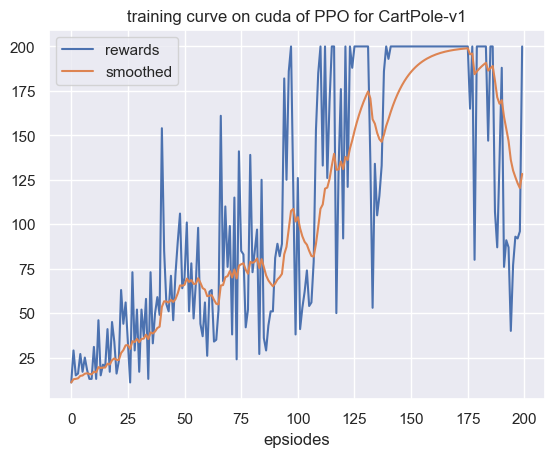

In [18]:
# 训练
env, agent = env_agent_config(cfg)
best_agent,res_dic = train(cfg, env, agent)

plot_rewards(res_dic['rewards'], cfg, tag="train")  

## 6.测试

开始测试！
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00
完成测试


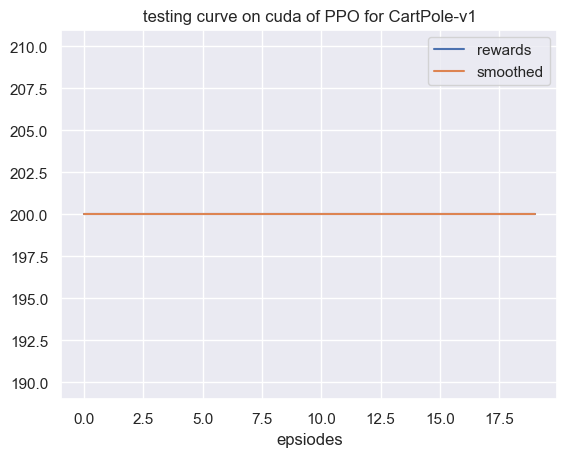

In [25]:
# 测试
res_dic = test(cfg, env, best_agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果

In [ ]:
def visual_game(cfg, env, agent):
    print("开始测试！")
    rewards = 0
    steps = 0
    state = env.reset()  # 重置环境，返回初始状态
    state = state[0]
    for _ in range(1000):
        steps+=1
        action = agent.predict_action(state)  # 选择动作
        next_state, reward, terminated, truncated, _ = env.step(action) # 更新环境，返回transition
        done = terminated or truncated
        state = next_state  # 更新下一个状态
        rewards += reward  # 累加奖励
        if done:
            break
    print(f"奖励：{rewards:.2f}, 步数：{steps}")
    
    print("完成测试")
    env.close()
    return

env = gym.make(cfg.env_name, render_mode='human') # 创建可视化环境
visual_game(cfg, env, best_agent)

开始测试！
奖励：285.00, 步数：285
完成测试
